In [1]:
import igl
import meshplot as mp
import numpy as np

In [2]:
# Meshplot uses two arrays to describe 3D objects: one for its vertices and one for its faces. 
# there are many data structures to represent 3D objects, however, the main advantage of this one
# is that it easily allows interchangable between libraries, including numpy and is generally memory
# friendly (caching)

v = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [1, 1, 1],
    [2, 1, 0]
])

f = np.array([
    [0, 1, 2],
    [1, 3, 2]
])

mp.plot(v, f)

/home/rage/anaconda3/envs/geo_computing/lib/python3.9/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.0, 0.5,…

In [4]:
v,f = igl.read_triangle_mesh('data/suzanne.stl')
mp.plot(v, f)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [5]:
bc = igl.barycenter(v, f)
assert(bc.shape == f.shape)
# select only left side and coloring
mp.plot(v, f[bc[:, 0]<0], c=v[:, 1])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

# Other visualizations

In [6]:
# Vector field visualization
nf = igl.per_face_normals(v, f, np.zeros(3))
assert(nf.shape == f.shape)
p = mp.plot(v, f)
p.add_lines(bc, bc+0.1*nf)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

1

In [9]:
v, f = igl.read_triangle_mesh("data/camelhead.off")
# Principal curvature visualization
pd1, pd2, pv1, pv2  = igl.principal_curvature(v, f) # this line crashes my kernel if I use suzanne.stl
p = mp.plot(v, f)
p.add_lines(v, v+5e-3*pd1, shading=dict(line_color='red'))
p.add_lines(v, v+5e-3*pd2, shading=dict(line_color='blue'))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.9967555…

2

# Save for offline visualization

In [ ]:
p.save('test.html') # and you can open it in any browser

# Mesh statistic

In [10]:
res = igl.is_edge_manifold(f) # check if mesh is manifold
print('The mesh is manifold? {}'.format(res))
irr = igl.is_irregular_vertex(v, f) # an irregular vertex has 6 incident edges
print(irr[:10])

The mesh is manifold? True
[False, True, True, True, False, True, True, False, True, False]


In [11]:
import plotly.graph_objects as go

dar = igl.doublearea(v,f)
go.Figure([go.Violin(x=dar)])

In [12]:
intang = igl.internal_angles(v, f)
print(intang.shape)
go.Figure([go.Histogram(x=intang.flatten()/np.pi*180)])

(22704, 3)


In [26]:
# let's see the face with largest internal angle
idx = intang.argmin()//3
# print(v[f[idx]])
p = mp.plot(v, f, shading=dict(wireframe=True))
p.add_points(v[f[idx]], shading={"point_color": "red", "point_size": 1})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.9967555…

1

# Texture mapping

In [40]:
vc, fc = igl.read_triangle_mesh("data/camelhead.off")

# Find the open boundary of the mesh
bnd = igl.boundary_loop(fc)

# Map the boundary to a circle, preserving edge proportions

# Harmonic parametrization for the internal vertices
uv = igl.harmonic_weights(vc, fc, bnd, bnd_uv, k=1)

# Generate an UV checker 2D image for better visualization
checker = mp.utils.gen_checkers(25, 50)

# Plotting the results
p = mp.subplot(vc, fc, uv=uv, s=[1, 2, 0],texture_data= checker)
mp.subplot(uv, fc, uv=uv, 
           shading={"wireframe": True, "wire_color": "red", "wire_width": 1.0}, 
            texture_data= checker,
           s=[1, 2, 1], data=p)

# Adding the boundary
p.rows[0][0].add_points(vc[bnd], shading={"point_size": 0.1});
lines = np.vstack([bnd, np.roll(bnd, -1)]).T
p.rows[0][0].add_edges(vc, lines, shading={"line_width": 1.0, "line_color": "red", "wireframe": True});


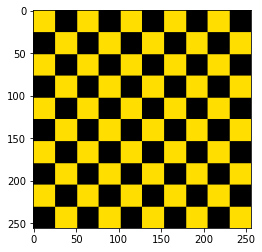

In [41]:
from matplotlib.pyplot import imshow
checker = mp.utils.gen_checkers(10, 10)
imshow(checker)

In [46]:
# back to the camel...we have a problem with UV distorsion. 
# There are a number of tools we can use to solve this problem

arap = igl.ARAP(v, f, 2, np.zeros(0))
uv_a = arap.solve(np.zeros((0, 0)), uv)

# It has the same number of boxes a larger "angular" stretch but best results in terms of distorsion
mp.plot(v, f, uv=uv_a, texture_data=checker)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.9967555…

# Shape Filtering and Smoothing

In [86]:
v, f = igl.read_triangle_mesh("data/cow.off")
mp.plot(v, f)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

$V_0 - V_1 = \lambda L V \quad \implies V_0 + \lambda V = V_1$ 

Then we multiply everything by a mass matrix such that the system is symmetric

$ (M + \lambda L_c) V_0 = M V_1$

In [87]:
from scipy.sparse.linalg import spsolve as solve
l = - igl.cotmatrix(v, f)
vs = [v]

for _ in range(10):
    m = igl.massmatrix(v, f)
    v = solve(m + 1e-3*l, m@v)
    vs.append(v)

In [88]:
p = mp.plot(vs[0], f)

@mp.interact(level=range(0, 10))
def mcf(level=0):
    p.update_object(vertices=vs[level])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

interactive(children=(Dropdown(description='level', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Output()…

# Miscellaneous

In [70]:
v, f = igl.read_triangle_mesh('data/bunny.obj')
mp.plot(v, f)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016860…

In [83]:
# to increase result quality you can subdivide the mesh
v, f = igl.loop(v, f)

vs = np.array([0]) # source array
vt = np.arange(len(v)) # target array
d = igl.exact_geodesic(v, f, vs, vt)

d = np.abs(np.sin(100*d)) 
# we can visualise the scalar field on the surface of the mesh
p = mp.plot(v, f, c=d, shading=dict(flat=False))

p.add_points(v[vs], shading=dict(point_size=0.05)) # the source of the scalar field

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016863…

1

# Deformation

In [95]:
v, f = igl.read_triangle_mesh("data/decimated-max.obj")
v[:,[0, 2]] = v[:,[2, 0]] # Swap X/Z axes
mp.plot(v, f)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(82.297483…

In [108]:
u = v.copy()
s = igl.read_dmat("data/decimated-max-selection.dmat")
b = np.array([[t[0] for t in [(i, s[i]) for i in range(0, v.shape[0])] if t[1] >= 0]]).T

# Boundary conditions
u_bc = np.zeros((b.shape[0], v.shape[1]))
v_bc = np.zeros((b.shape[0], v.shape[1]))

for bi in range(b.shape[0]):
    v_bc[bi] = v[b[bi]]

    if s[b[bi]] == 0: # Don't move handle 0
        u_bc[bi] = v[b[bi]]
    elif s[b[bi]] == 1: # Move handle 1 down
        u_bc[bi] = v[b[bi]] + np.array([[0, -50, 0]])
    else: # Move other handles forward
        u_bc[bi] = v[b[bi]] + np.array([[-25, 0, 0]])
        
p = mp.plot(v, f, s, shading={"colormap": "tab10"}, return_plot=True)

@mp.interact(deformation_field=True, step=(-1, 3.0))
def update(deformation_field, step=0.0):
    # Determine boundary conditions
    u_bc_anim = v_bc + step * (u_bc - v_bc)

    if deformation_field:
        d_bc = u_bc_anim - v_bc
        d = igl.harmonic_weights(v, f, b, d_bc, 2)
        u = v + d
    else:
        u = igl.harmonic_weights(v, f, b, u_bc_anim, 2)
    p.update_object(vertices=u)
p

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(82.297483…

interactive(children=(Checkbox(value=True, description='deformation_field'), FloatSlider(value=0.0, descriptio…